In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score ,f1_score,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2
from data_prep import df_prep  
from data_prep import  NLP_Vectorizer
from data_prep import parse_line
from model_src import NLP_model


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/nathan/nltk_data...
[nltk_data]    |   Package movie_reviews is already

In [3]:
col_names = ['marketplace','customer_id','review_id','product_id','product_parent','product_title','product_category','star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date']
cols = {}
for i in range(len(col_names)):
    print (str(i)+': '+col_names[i])
    cols[col_names[i]] = i

0: marketplace
1: customer_id
2: review_id
3: product_id
4: product_parent
5: product_title
6: product_category
7: star_rating
8: helpful_votes
9: total_votes
10: vine
11: verified_purchase
12: review_headline
13: review_body
14: review_date


In [4]:
np.random.seed(500)
df = pd.read_csv('data/Spark_Pulls/us_Books_v1_02.csv')


df = df.sample(frac=.1, random_state=1)
len(df)

6672

In [5]:
Corpus = df_prep(df,.4,.0)

0
1000
2000
3000
4000
5000
6000


In [6]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus[['text','text_final','help_score','help_votes','stars']],Corpus['label'],test_size=0.3)



Train_X_Vector, Test_X_Vector, Train_Y, Test_Y = vectorize_df(Train_X['text_final'], Test_X['text_final'], Train_Y, Test_Y,'TF_IDF')





In [7]:
TF_IDF = NLP_Vectorizer('CV',{'max_features':2000,'ngram_range':(1,3)})
orig_Test_Y = Test_Y
orig_Train_Y = Train_Y
Test_Y = TF_IDF.encode_Y(Test_Y)
Train_Y = TF_IDF.encode_Y(Train_Y)

In [8]:
TF_IDF.fit(Train_X['text_final'])
Train_X_Vector = TF_IDF.transform(Train_X['text_final'])
Test_X_Vector = TF_IDF.transform(Test_X['text_final'])

In [9]:
list(Train_X['text_final'])[0] == parse_line(list(Train_X['text'])[0])

True

In [10]:
NVB = NLP_model('SVC')

In [11]:
NVB.fit(Train_X_Vector,Train_Y)

In [12]:
NVB_predict = NVB.predict(Test_X_Vector)

In [13]:
accuracy_score(NVB_predict,Test_Y)

0.5993945509586277

In [14]:
NVB_predict

array([1, 0, 1, ..., 1, 0, 0])

In [15]:
sum(NVB_predict)/len(NVB_predict)

0.6160443995963673

In [16]:
sum(Test_Y)/len(Test_Y)

0.6301715438950555

In [17]:
Test_X['preds'] = NVB_predict
Test_X['actual'] = Test_Y

Test_X['correct'] = Test_X['preds'] == Test_X['actual']

In [18]:
Test_X['actual']

43051    1
64017    1
61024    1
54705    0
13772    1
        ..
48622    0
58202    0
54099    1
22738    1
41426    1
Name: actual, Length: 1982, dtype: int64

/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/nathan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.496633  , 0.85016835, 0.82491582, 0.77441077, 0.85016835,
        1.66666667, 1.1026936 , 1.15319865, 1.27946128, 1.0016835 ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

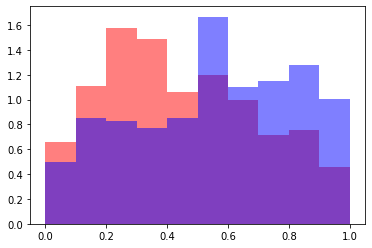

In [19]:
plt.hist(Test_X[Test_X['correct']==False]['help_score'],bins=10,normed=True,color='red',alpha=.5)
plt.hist(Test_X[Test_X['correct']==True]['help_score'],bins=10,normed=True,color='blue',alpha=.5)

In [20]:
NVB_predict_proba = NVB.predict_proba(Test_X_Vector)

AttributeError: predict_proba is not available when  probability=False

In [ ]:
fpr, tpr, thresholds = roc_curve(Test_Y,NVB_predict_proba[:,1])

In [ ]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive')
plt.ylabel('True Positive')


In [ ]:
plt.hist(Train_X['help_score'])

In [ ]:
def parse_thresh(probs,thresh):
    new_predict = []
    for prob in probs:
        if prob>=thresh:
            new_predict.append(1)
        else:
            new_predict.append(0)
    return new_predict

In [ ]:
NVB_predict == parse_thresh(NVB_predict_proba[:,1],.5)

In [ ]:
max_f1 = 0
for i in np.linspace(0,1,10):
    check_pred = parse_thresh(NVB_predict_proba[:,1],i)
    #print(str(i)+" "+str(f1_score(Test_Y,check_pred)))
    

In [ ]:
precision, recall, thresholds = precision_recall_curve(Test_Y,NVB_predict_proba[:,1])


In [ ]:
plt.plot(recall,precision)
plt.ylabel('precision')
plt.xlabel('recall')